In [1]:
import sys
import os
sys.path.append("/disk2/iping/NTU_ADL/ADL_hw1/hw1_sample_code/src")
import pickle
from argparse import Namespace
from typing import Tuple, Dict

import torch
from torch import nn
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import torch.nn.functional as F

from dataset import SeqTaggingDataset
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
class Encoder(nn.Module):
    def __init__(self,
                 embedding_path,
                 embed_size,
                 rnn_hidden_size,
                 rnn_num_layers) -> None:
        super(Encoder, self).__init__()
        with open(embedding_path, 'rb') as f:
            embedding = pickle.load(f)
        embedding_weight = embedding.vectors
        self.embedding = nn.Embedding.from_pretrained(embedding_weight)

        # TODO (init a LSTM/RNN)
        self.rnn = nn.GRU(input_size = embed_size,
                          hidden_size = rnn_hidden_size,
                          num_layers = rnn_num_layers,
                          bidirectional=True,
                          batch_first=True)

    def forward(self, idxs) -> Tuple[torch.tensor, torch.tensor]:
        embed = self.embedding(idxs)
        output, state = self.rnn(embed)
        return output, state

class SeqTagger(pl.LightningModule):
    def __init__(self, hparams) -> None:
        super(SeqTagger, self).__init__()
        self.hparams = hparams
        self.criterion = nn.BCEWithLogitsLoss(
            reduction='mean', 
            pos_weight=torch.tensor(hparams.pos_weight))
        self.encoder = Encoder(hparams.embedding_path,
                               hparams.embed_size,
                               hparams.rnn_hidden_size,
                               hparams.rnn_num_layers)
        self.proj_1 = nn.Linear(2*self.encoder.rnn.hidden_size, 256)
        self.proj_2 = nn.Linear(256, 128)
        self.proj_3 = nn.Linear(128,1)
        
        self.ans = []

    def forward(self, idxs) -> torch.tensor:
        # TODO
        # take the output of encoder
        # project it to 1 dimensional tensor
        enc_output, state = self.encoder(idxs)
        l1 = F.relu(self.proj_1(enc_output))
        l2 = F.relu(self.proj_2(l1))
        
        logits = self.proj_3(l2)
    
        return logits

    def _unpack_batch(self, batch) -> Tuple[torch.tensor, torch.tensor]:
        try:
            return batch['text'], batch['label'].float()
        except:
            return batch['text']

    def _calculate_loss(self, y_hat, y) -> torch.tensor:
        # TODO
        # calculate the logits
        # plz use BCEWithLogit
        # adjust pos_weight!
        # MASK OUT PADDINGS' LOSSES!
        y_hat = y_hat.reshape(-1)
        y = y.reshape(-1)
        non_ignore = torch.where(y!= self.hparams.ignore_idx)[0]    

        loss = self.criterion(y_hat[non_ignore], y[non_ignore])
        
        return loss

    def training_step(self, batch, batch_nb) -> Dict:
        x, y = self._unpack_batch(batch)
        logit = self.forward(x)
        loss = self._calculate_loss(logit, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb) -> Dict:
        x, y = self._unpack_batch(batch)
        logit = self.forward(x)
        loss = self._calculate_loss(logit, y)
        return {'val_loss': loss}
    
    def test_step(self, batch, batch_nb) -> list:
        x = self._unpack_batch(batch)
        logit = self.forward(x)
        pred = torch.sigmoid(logit)
        pred = pred > self.hparams.threshold
        b,s,w = pred.shape
        pred = pred.view(b,s)
        pred = pred.type(torch.uint8).tolist()
        return pred
        
    def test_epoch_end(self, outputs) -> Dict:
        for pred in outputs:
            self.ans.extend(pred)
        print('Now threshold: ' + str(self.hparams.threshold))
        return {'test': 0}
    
    def validation_epoch_end(self, outputs) -> Dict:
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}
    
    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

    def _load_dataset(self, dataset_path: str) -> SeqTaggingDataset:
        with open(dataset_path, 'rb') as f:
            dataset = pickle.load(f)
        return dataset

    def train_dataloader(self):
        dataset = self._load_dataset(self.hparams.train_dataset_path)
        return DataLoader(dataset, 
                          self.hparams.batch_size, 
                          shuffle=True,
                          collate_fn=dataset.collate_fn)

    def val_dataloader(self):
        dataset = self._load_dataset(self.hparams.valid_dataset_path)
        return DataLoader(dataset, 
                          self.hparams.batch_size, 
                          collate_fn=dataset.collate_fn)
    
    def test_dataloader(self):
        dataset = self._load_dataset(self.hparams.test_dataset_path)
        return DataLoader(dataset, 
                          self.hparams.test_batch_size, 
                          collate_fn=dataset.collate_fn)
    
class MyPrintingCallback(pl.Callback):
    
    def on_validation_start(self, trainer, pl_module):
        print('validation starts')
        
    def on_validation_end(self, trainer, pl_module):
        print('validation end')

In [3]:
data_path = '/disk2/iping/NTU_ADL/ADL_hw1/data'
hparams = Namespace(**{
    'embedding_path': data_path + "/embedding_tag.pkl",
    'embed_size': 300,

    'train_dataset_path': data_path + "/train_tag.pkl",
    'valid_dataset_path': data_path + "/valid_tag.pkl",
    'test_dataset_path': data_path + "/test_tag.pkl",
    'ignore_idx': -100,

    'batch_size': 512,
    'test_batch_size': 256,
    
    'pos_weight': 5,
    
    'lr': 1e-03,
    'rnn_num_layers': 3,
    
    'threshold': 0.5,

    'rnn_hidden_size': 256,
})


In [11]:
PATH_checkpoint = "/disk2/iping/NTU_ADL/ADL_hw1/extractive_model/"
PATH_checkpoint += "model_pos5_{epoch:02d}"

checkpoint_callback = ModelCheckpoint(
    filepath=PATH_checkpoint,
    save_top_k=True,
    verbose=True,
    monitor='avg_val_loss',
    mode='min',
    prefix=''
)

seq_tagger = SeqTagger(hparams)
trainer = pl.Trainer(gpus=1, max_epochs=8, checkpoint_callback=checkpoint_callback)
trainer.fit(seq_tagger)

1

In [4]:
from tqdm import tqdm
PATH_checkpoint = "/disk2/iping/NTU_ADL/ADL_hw1/extractive_model/"
PATH_checkpoint += "best_extractive_model.ckpt"
seq_tagger = SeqTagger.load_from_checkpoint(PATH_checkpoint)

In [6]:
# if pl test doesnt work
with open(data_path + "/test_tag.pkl", 'rb') as f:
    dataset = pickle.load(f)
test_loader = DataLoader(dataset, 
                         64, 
                         collate_fn=dataset.collate_fn)
device = 'cuda:0'
trange_test = tqdm(enumerate(test_loader), total=len(test_loader), desc = 'Test')
ans = []
for z, (batch) in trange_test:
    x = seq_tagger._unpack_batch(batch)
    x = x.to(device)
    seq_tagger.to(device)
    logit = seq_tagger.forward(x)
    pred = torch.sigmoid(logit)
    pred = pred > hparams.threshold
    b,s,w = pred.shape
    pred = pred.view(b,s)
    pred = pred.type(torch.uint8).tolist()
    ans.extend(pred)

Test: 100%|██████████| 313/313 [00:16<00:00, 18.66it/s]


In [12]:
with open(data_path + "/valid_tag.pkl", 'rb') as f:
    valid_dataset = pickle.load(f)

In [13]:
# Ratio of "1" should bigger than 50%
import numpy as np
ans_jsonl = []
THRESHOLD_chosed = 0.1
for data, a in zip(valid_dataset, ans):
    ratio_ones = []
    for i in data['sent_range']:
        now_sent = a[i[0]: i[1]]
        ratio_ones.append(np.sum(now_sent) / len(now_sent))
        
    pos = np.where(np.array(ratio_ones) >= THRESHOLD_chosed)[0].tolist()
    ans_jsonl.append({'id':data['id'],'predict_sentence_index':pos})

/home/iping/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/iping/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()


In [19]:


len(valid_dataset[0]['sent_range'])

11

In [20]:
ans_jsonl[0]['predict_sentence_index']

{'id': '2000000', 'predict_sentence_index': [1, 4]}

In [14]:
import json
ans_jsObj = json.dumps(ans_jsonl) 

In [15]:
PATH_save = "/disk2/iping/NTU_ADL/ADL_hw1/for_testing/"
filename_save = 'output_pos5_fp0.2_best'
with open(PATH_save+filename_save+'.jsonl', 'w') as outfile:
    for entry in ans_jsonl:
        json.dump(entry, outfile)
        outfile.write('\n')

In [23]:
# Report 4 hist
import numpy as np
import matplotlib.pyplot as plt
all_relative = []
for ans, valid in zip(ans_jsonl, valid_dataset):
    ratio = np.array(ans['predict_sentence_index']) / len(valid['sent_range'])
    all_relative.extend(ratio.tolist())

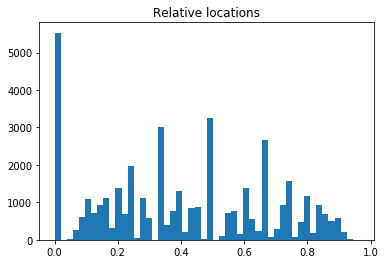

In [32]:
plt.hist(np.array(all_relative), bins=50)
plt.title('Relative locations')

In [27]:
counts, bins = np.histogram(all_relative)